In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import seaborn as sns
import quandl

sns.set_style('darkgrid')
%matplotlib inline

In [3]:
# Set API KEY: export API_KEY="YOUR_KEY" or %env API_KEY=YOUR_KEY
quandl.ApiConfig.api_key = os.environ['API_KEY']

In [4]:
# We'll first get APPL close data for Q1 of 2018 and get the 
# SPY ETF data for the same time horizon to use as our benchmark
start_date, end_date = '2018-01-01', '2018-04-01'

asset = quandl.get('WIKI/AAPL', start_date=start_date, end_date=end_date)['Close']
benchmark = quandl.get('VOLX/VOLSPY', start_date=start_date, end_date=end_date)['URP'][:-2]

In [5]:
# First row is null, since we're calculating the percent change
asset_returns = asset.pct_change(1)[1:]
benchmark_returns = benchmark.pct_change(1)[1:]

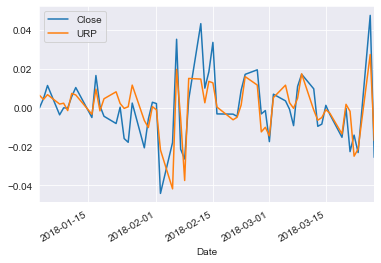

In [6]:
# By plotting the percentage returns, we can see that AAPL generally
# follows the market, however when it doesn't follow the market, this
# is called the `alpha`.
asset_returns.plot()
benchmark_returns.plot()
plt.legend()

In [7]:
asset_values = asset_returns.values
benchmark_values = benchmark_returns.values

In [8]:
# We need to add a constant, so we can get the intercept
benchmark_constant = sm.add_constant(benchmark_values)

In [9]:
model = regression.linear_model.OLS(asset_values, benchmark_constant).fit()

In [10]:
alpha, beta = model.params

Text(0, 0.5, 'AAPL Returns')

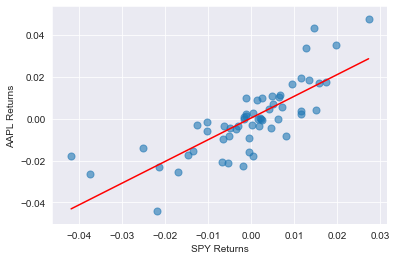

In [11]:
# We can see that there is a relationship between APPL and the 
# rest of the market. When the market goes up, so too does the 
# S&P 500. We will use hedging to isolate the alpha behaviour.
minimum_benchmark = benchmark_returns.values.min()
maximum_benchmark = benchmark_returns.values.max()

benchmark_line = np.linspace(minimum_benchmark, maximum_benchmark, 100)
y = benchmark_line * beta + alpha

plt.plot(benchmark_line, y, 'r')
plt.scatter(benchmark_returns, asset_returns, alpha=0.6, s=50)
plt.xlabel('SPY Returns')
plt.ylabel('AAPL Returns')

In [12]:
# We can create a simple hedge, by turning the beta negative, so
# they cancel each other out, by essentially shorting each other out
hedge = -1 * (beta * benchmark_returns) + asset_returns

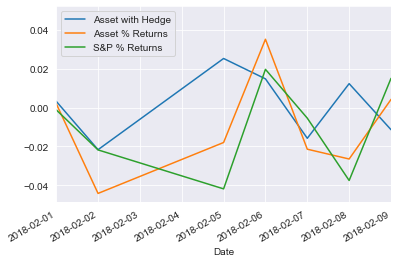

In [13]:
# Now, when the market drops, whilst before the asset would follow
# suit, however, now with the hedge, the asset is less affected
hedge.plot(label='Asset with Hedge')
asset_returns.plot(label='Asset % Returns')
benchmark_returns.plot(label='S&P % Returns')
plt.xlim(['2018-02-01', '2018-02-09'])
plt.legend()